In [1]:
import cv2
import numpy as np
from skimage import filters, morphology, measure, segmentation
import matplotlib.pyplot as plt

def preprocess_text_image(image_path, output_path=None):
    """
    Advanced image preprocessing for text extraction with multiple techniques.
    
    Parameters:
    -----------
    image_path : str
        Path to the input image
    output_path : str, optional
        Path to save the processed image. If None, doesn't save.
        
    Returns:
    --------
    dict
        Dictionary containing processed images at different stages
    """
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image at {image_path}")
    
    # Store original and processed images
    results = {"original": image.copy()}
    
    # Convert to RGB (OpenCV uses BGR)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results["rgb"] = image_rgb.copy()
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    results["grayscale"] = gray.copy()
    
    # Background removal using Otsu's method
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    results["binary_otsu"] = binary.copy()
    
    # Adaptive thresholding for varying illumination
    adaptive_binary = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 10
    )
    results["adaptive_binary"] = adaptive_binary.copy()
    
    # Background cleaning using morphological operations
    kernel = np.ones((3, 3), np.uint8)
    morph_clean = cv2.morphologyEx(adaptive_binary, cv2.MORPH_CLOSE, kernel)
    morph_clean = cv2.morphologyEx(morph_clean, cv2.MORPH_OPEN, kernel)
    results["morphological_clean"] = morph_clean.copy()
    
    # Edge detection for text boundaries
    edges = cv2.Canny(gray, 50, 150)
    results["edges"] = edges.copy()
    
    # Gaussian blur for noise reduction
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    results["gaussian_blur"] = blurred.copy()
    
    # Sharpen the image for better text clarity
    kernel_sharpen = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharpened = cv2.filter2D(gray, -1, kernel_sharpen)
    results["sharpened"] = sharpened.copy()
    
    # Regional Gaussian processing
    def apply_regional_gaussian(img):
        # Split image into regions
        h, w = img.shape
        regions = []
        
        # Create 4 regions
        regions.append(img[0:h//2, 0:w//2])  # Top-left
        regions.append(img[0:h//2, w//2:w])  # Top-right
        regions.append(img[h//2:h, 0:w//2])  # Bottom-left
        regions.append(img[h//2:h, w//2:w])  # Bottom-right
        
        # Process each region with different Gaussian parameters
        processed_regions = []
        sigmas = [0.5, 1.0, 1.5, 2.0]
        
        for i, region in enumerate(regions):
            # Apply Gaussian with different sigma for each region
            processed = filters.gaussian(region, sigma=sigmas[i], preserve_range=True).astype(np.uint8)
            processed_regions.append(processed)
        
        # Recombine the image
        result = np.zeros_like(img)
        result[0:h//2, 0:w//2] = processed_regions[0]
        result[0:h//2, w//2:w] = processed_regions[1]
        result[h//2:h, 0:w//2] = processed_regions[2]
        result[h//2:h, w//2:w] = processed_regions[3]
        
        return result
    
    regional_gaussian = apply_regional_gaussian(gray)
    results["regional_gaussian"] = regional_gaussian.copy()
    
    # Advanced text region extraction using local binary patterns
    def get_text_regions(img):
        # Apply local binary pattern-like approach
        ret, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
        # Find connected components
        labeled = measure.label(binary)
        
        # Filter regions by properties
        regions_props = measure.regionprops(labeled)
        
        # Create a mask for text regions
        text_mask = np.zeros_like(binary)
        
        for region in regions_props:
            # Filter by region properties (typical for text)
            if (region.area > 50 and  # Not too small
                region.area < img.size / 10 and  # Not too large
                region.eccentricity > 0.5):  # Elongated (like text)
                
                # Add the region to the mask
                for coord in region.coords:
                    text_mask[coord[0], coord[1]] = 255
        
        return text_mask
    
    text_regions = get_text_regions(gray)
    results["text_regions"] = text_regions.copy()
    
    # Final refined output
    # Combine the best aspects of various techniques
    final_output = cv2.bitwise_and(sharpened, sharpened, mask=text_regions)
    
    # Enhance contrast in the final output
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    final_output = clahe.apply(final_output)
    
    results["final_output"] = final_output.copy()
    
    # Save result if output path is provided
    if output_path:
        cv2.imwrite(output_path, final_output)
        print(f"Processed image saved to {output_path}")
    
    return results

def display_results(results):
    """
    Display the original image and various processed versions in a grid.
    """
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.flatten()
    
    key_order = [
        "original", "grayscale", "binary_otsu", "adaptive_binary",
        "morphological_clean", "edges", "gaussian_blur", "sharpened",
        "regional_gaussian", "text_regions", "final_output"
    ]
    
    for i, key in enumerate(key_order):
        if key in results:
            if key == "original" or key == "rgb":
                axes[i].imshow(cv2.cvtColor(results[key], cv2.COLOR_BGR2RGB))
            else:
                axes[i].imshow(results[key], cmap='gray')
            axes[i].set_title(key.replace('_', ' ').title())
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
# Additional utility functions for more specific text preprocessing

def deskew_image(image):
    """
    Deskew (straighten) text in an image.
    """
    # Convert to grayscale and binarize
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    # Calculate skew angle
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    
    # Rotate image to deskew
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    return rotated

def enhance_text_contrast(image):
    """
    Enhance text contrast using advanced techniques.
    """
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    
    # Apply unsharp masking for further enhancement
    gaussian = cv2.GaussianBlur(enhanced, (0, 0), 3)
    unsharp_mask = cv2.addWeighted(enhanced, 1.5, gaussian, -0.5, 0)
    
    return unsharp_mask

def remove_noise(image, strength=10):
    """
    Advanced noise removal using non-local means denoising.
    """
    if len(image.shape) == 3:
        denoised = cv2.fastNlMeansDenoisingColored(image, None, strength, strength, 7, 21)
    else:
        denoised = cv2.fastNlMeansDenoising(image, None, strength, 7, 21)
    
    return denoised

In [3]:
image_path = "data/mine.png"
output_path = "data/processed_image.png"

In [2]:
def display_image(img, title="Image", cmap=None, figsize=(10, 10)):
    """Displays an image using matplotlib."""
    plt.figure(figsize=figsize)
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        # Convert BGR (OpenCV default) to RGB for matplotlib
        if len(img.shape) == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap='gray') # Keep grayscale if it's already gray
    plt.title(title)
    plt.axis('off')
    plt.show()


Processed image saved to data/processed_image.png


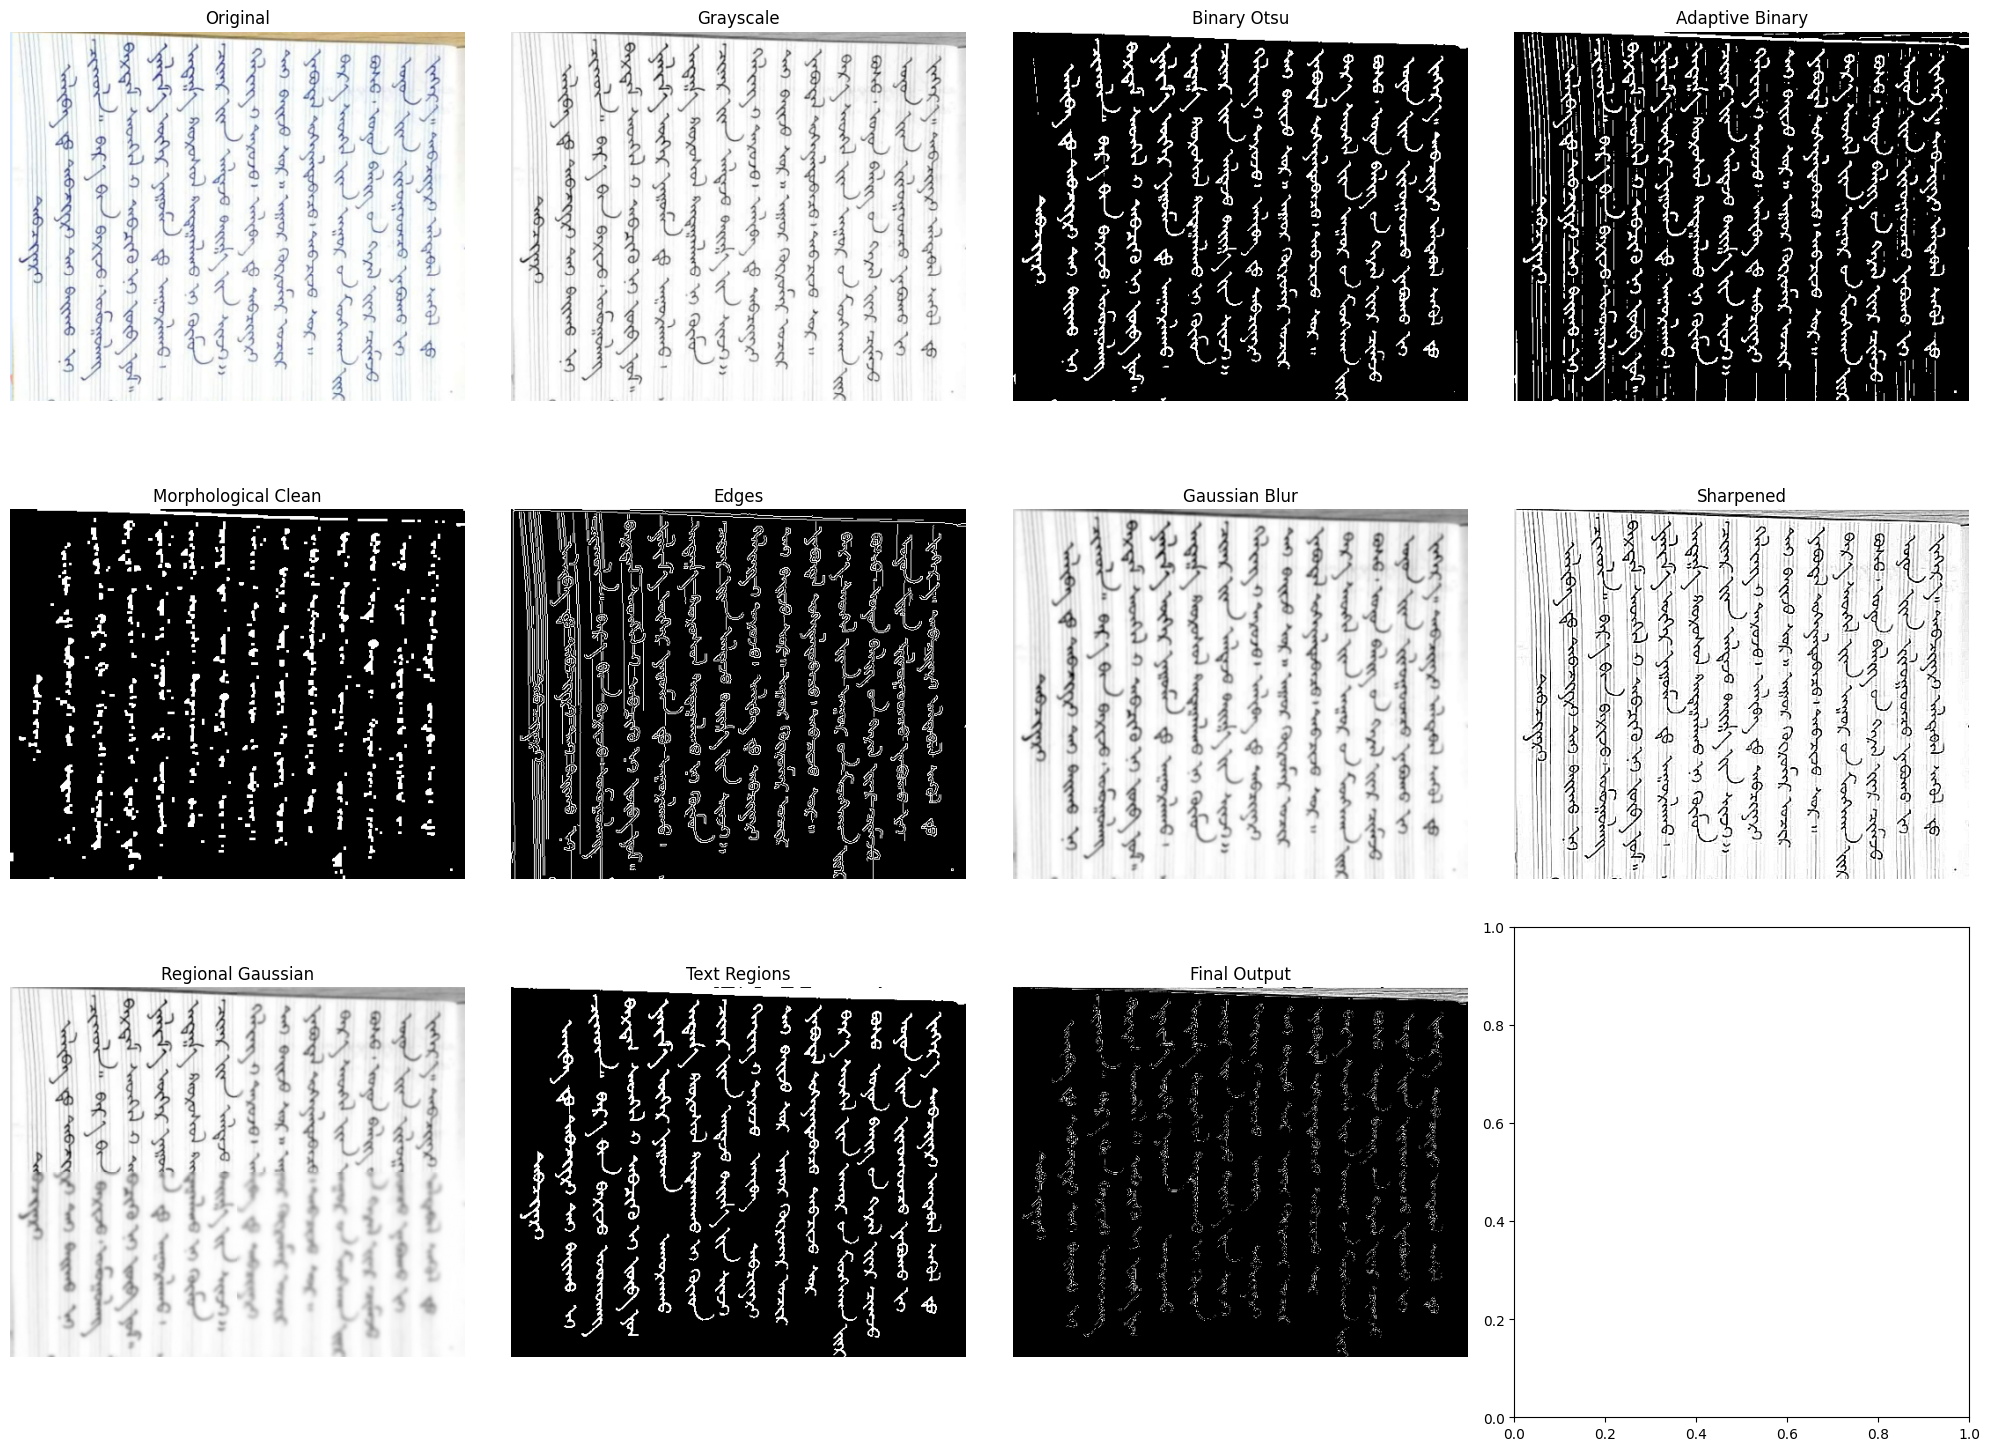

In [4]:
image_path = "data/mine.png"
output_path = "data/processed_image.png"

try:
    # Process the image
    results = preprocess_text_image(image_path, output_path)
    
    # Display results
    display_results(results)
    
except Exception as e:
    print(f"Error: {e}")

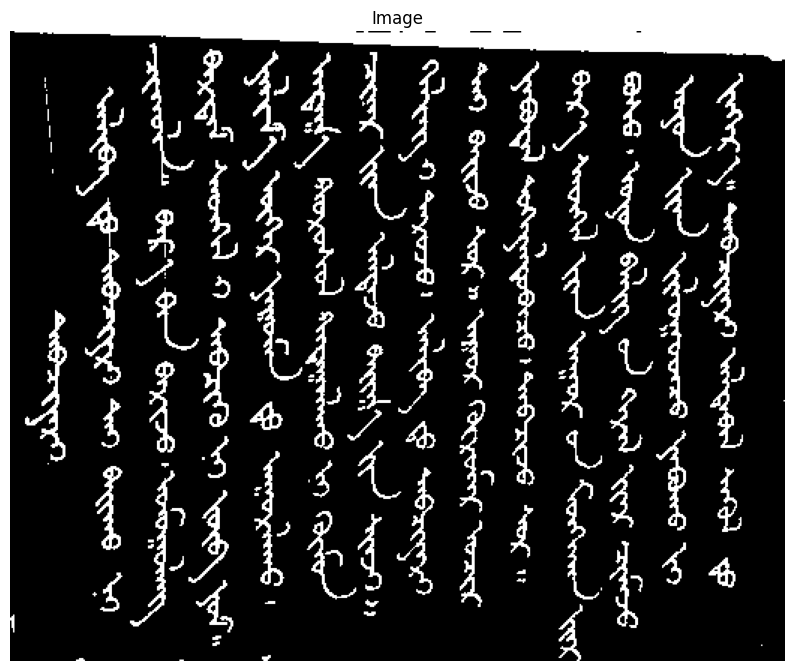

In [11]:

image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Background removal using Otsu's method
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# kernel_sharpen = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
# sharpened = cv2.filter2D(binary, -1, kernel_sharpen)

# sharpened = cv2.filter2D(binary, -1, sharpened)

display_image(binary)

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def enhanced_otsu_text_processor(image_path, output_path=None):
    """
    Process text images using a combination of Otsu thresholding and sharpening filters
    to enhance text clarity and remove background.
    
    Parameters:
    -----------
    image_path : str
        Path to the input image
    output_path : str, optional
        Path to save the processed image. If None, doesn't save.
        
    Returns:
    --------
    dict
        Dictionary containing processed images at different stages
    """
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image at {image_path}")
    
    # Store results at each step
    results = {"original": image.copy()}
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    results["grayscale"] = gray.copy()
    
    # Sharpen the image using different kernels for comparison
    # Kernel 1: Standard sharpening
    kernel_sharpen_1 = np.array([[-1, -1, -1],
                                 [-1,  9, -1],
                                 [-1, -1, -1]])
    
    # Kernel 2: Stronger sharpening
    kernel_sharpen_2 = np.array([[-1, -1, -1],
                                 [-1, 10, -1],
                                 [-1, -1, -1]])
    
    # Kernel 3: Edge enhancement
    kernel_sharpen_3 = np.array([[0, -1, 0],
                                 [-1, 5, -1],
                                 [0, -1, 0]])
    
    # Apply each sharpening kernel
    sharpened_1 = cv2.filter2D(gray, -1, kernel_sharpen_1)
    results["standard_sharp"] = sharpened_1.copy()
    
    sharpened_2 = cv2.filter2D(gray, -1, kernel_sharpen_2)
    results["strong_sharp"] = sharpened_2.copy()
    
    sharpened_3 = cv2.filter2D(gray, -1, kernel_sharpen_3)
    results["edge_enhance"] = sharpened_3.copy()
    
    # Apply Otsu's thresholding to each sharpened image
    ret1, otsu_1 = cv2.threshold(sharpened_1, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    results["otsu_standard_sharp"] = otsu_1.copy()
    
    ret2, otsu_2 = cv2.threshold(sharpened_2, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    results["otsu_strong_sharp"] = otsu_2.copy()
    
    ret3, otsu_3 = cv2.threshold(sharpened_3, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    results["otsu_edge_enhance"] = otsu_3.copy()
    
    # Enhanced processing: combine results with morphological operations
    
    # Create kernels for morphological operations
    kernel_small = np.ones((2, 2), np.uint8)
    kernel_medium = np.ones((3, 3), np.uint8)
    
    # Clean up the best result (usually standard or edge enhanced)
    cleaned = cv2.morphologyEx(otsu_1, cv2.MORPH_CLOSE, kernel_medium)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel_small)
    results["cleaned"] = cleaned.copy()
    
    # Enhanced version with noise removal
    denoised = cv2.fastNlMeansDenoising(sharpened_1, None, 10, 7, 21)
    ret4, enhanced_otsu = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    enhanced_cleaned = cv2.morphologyEx(enhanced_otsu, cv2.MORPH_CLOSE, kernel_medium)
    enhanced_cleaned = cv2.morphologyEx(enhanced_cleaned, cv2.MORPH_OPEN, kernel_small)
    results["enhanced_final"] = enhanced_cleaned.copy()
    
    # Final output: invert back to black text on white background if needed
    final_output = cv2.bitwise_not(enhanced_cleaned)
    results["final_output"] = final_output.copy()
    
    # Save the final result if output path is provided
    if output_path:
        cv2.imwrite(output_path, final_output)
        print(f"Processed image saved to {output_path}")
    
    return results

def display_results(results):
    """
    Display the original image and various processed versions in a grid.
    """
    # Determine grid size based on number of results
    n_images = len(results)
    cols = 3
    rows = (n_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # Display each image
    for i, (key, img) in enumerate(results.items()):
        if i < len(axes):
            if key == "original":
                axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            else:
                axes[i].imshow(img, cmap='gray')
            axes[i].set_title(key.replace('_', ' ').title())
            axes[i].axis('off')
    
    # Hide any unused subplots
    for i in range(n_images, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

def batch_process_images(image_paths, output_dir="processed_images"):
    """
    Process multiple images with the enhanced Otsu and sharpening method.
    
    Parameters:
    -----------
    image_paths : list
        List of paths to input images
    output_dir : str
        Directory to save processed images
    """
    import os
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    for img_path in image_paths:
        # Get the filename without extension
        base_name = os.path.basename(img_path)
        file_name, file_ext = os.path.splitext(base_name)
        
        # Create output path
        output_path = os.path.join(output_dir, f"{file_name}_processed{file_ext}")
        
        # Process the image
        print(f"Processing {img_path}...")
        try:
            results = enhanced_otsu_text_processor(img_path, output_path)
            print(f"Successfully processed and saved to {output_path}")
        except Exception as e:
            print(f"Error processing {img_path}: {e}")



Processed image saved to data/processed_image.png


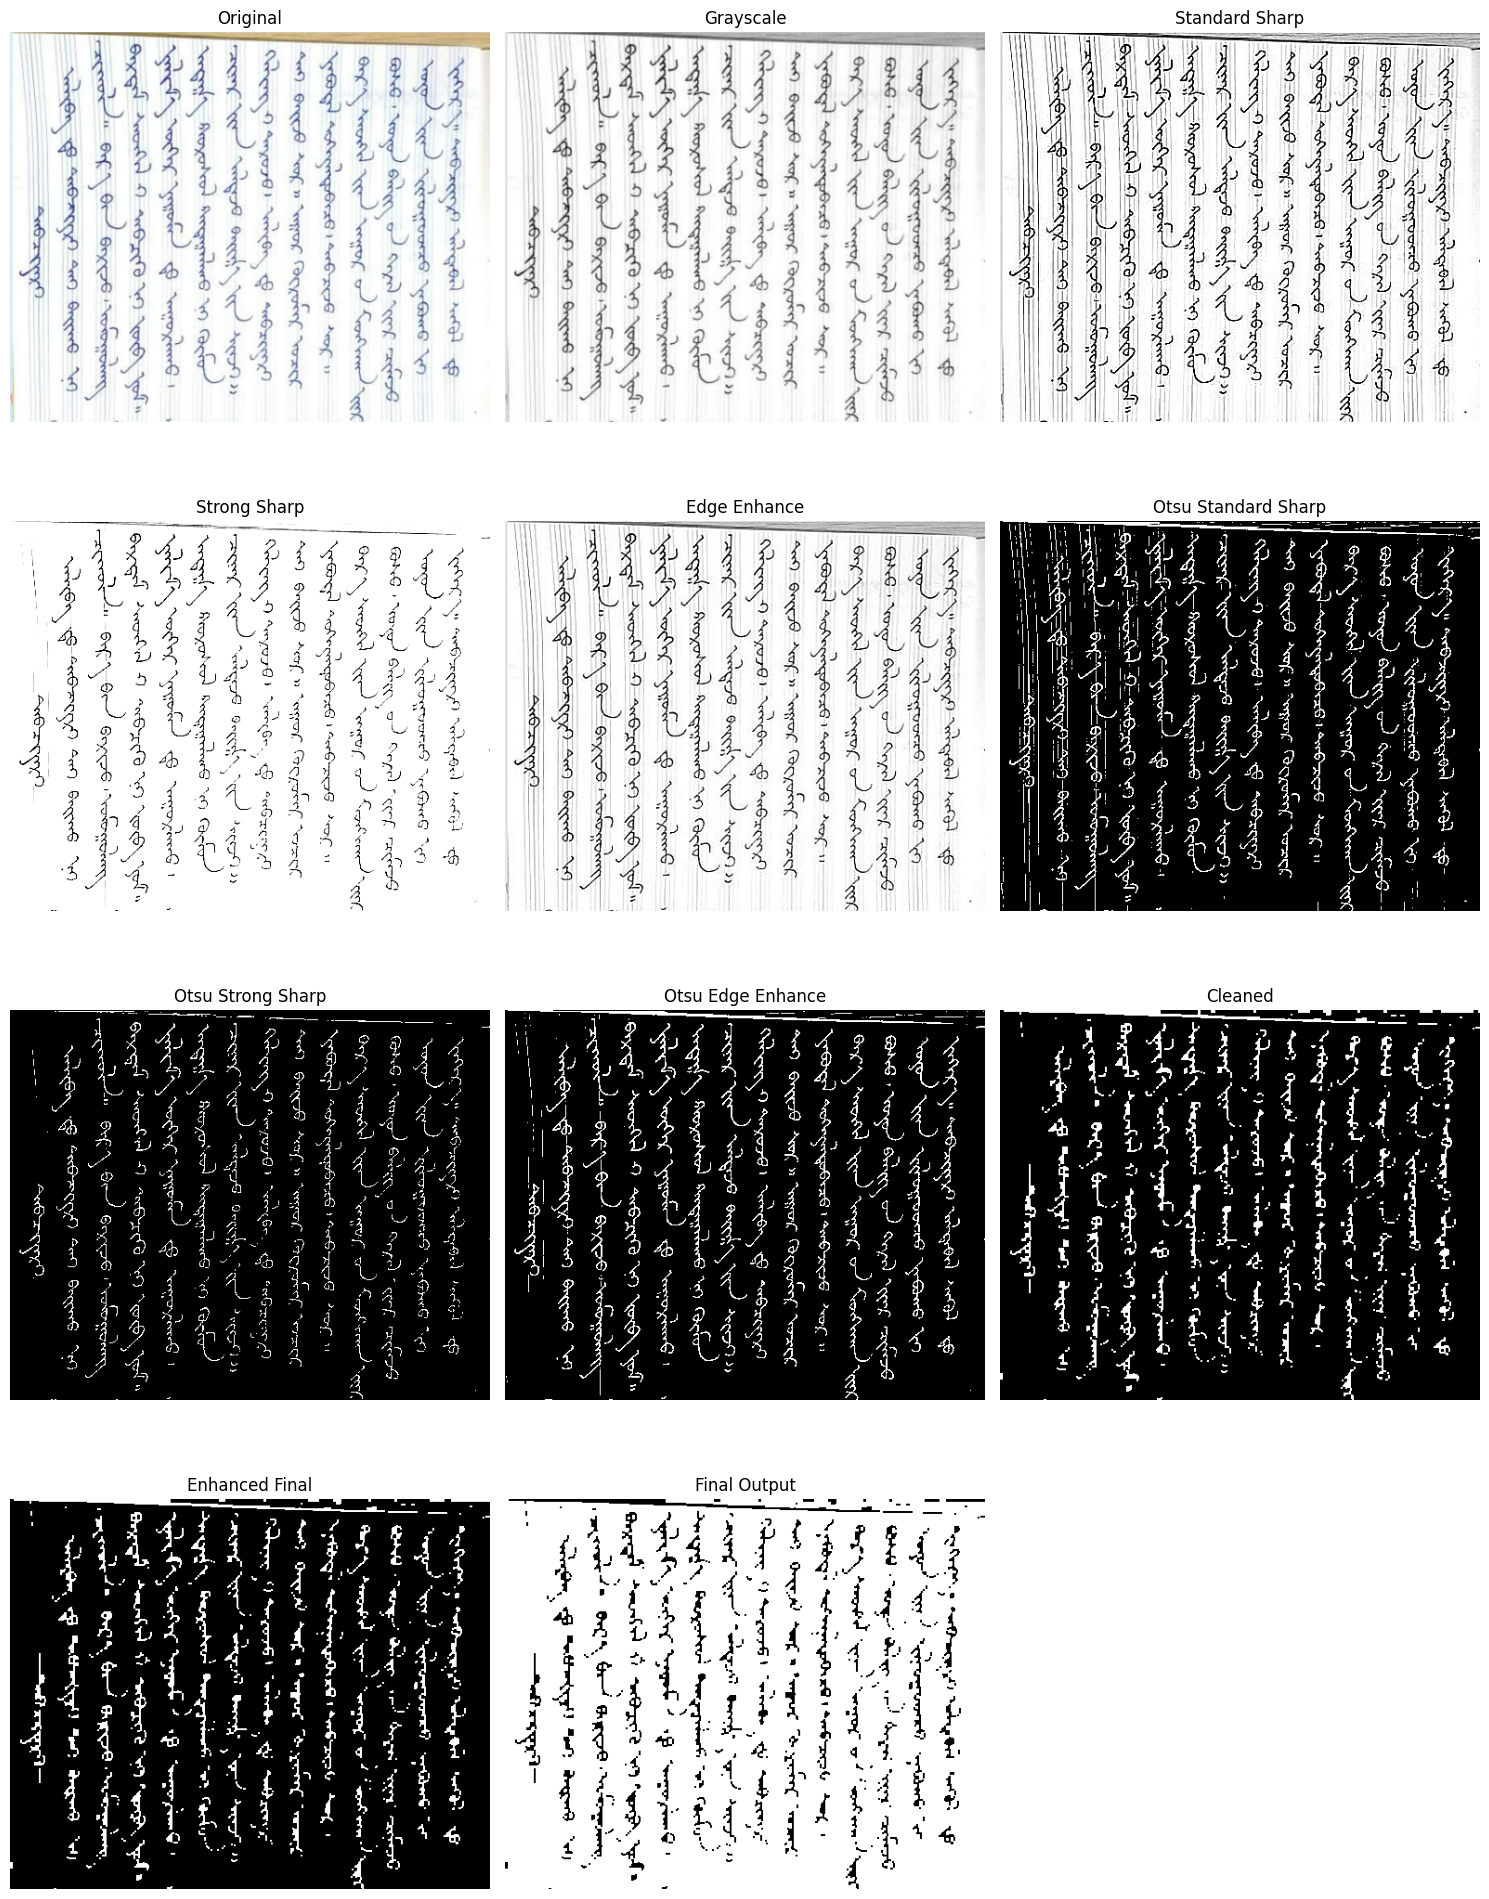

In [5]:
image_path = "data/mine.png"
output_path = "data/processed_image.png"
results = enhanced_otsu_text_processor(image_path, output_path)
        
# Display results
display_results(results)

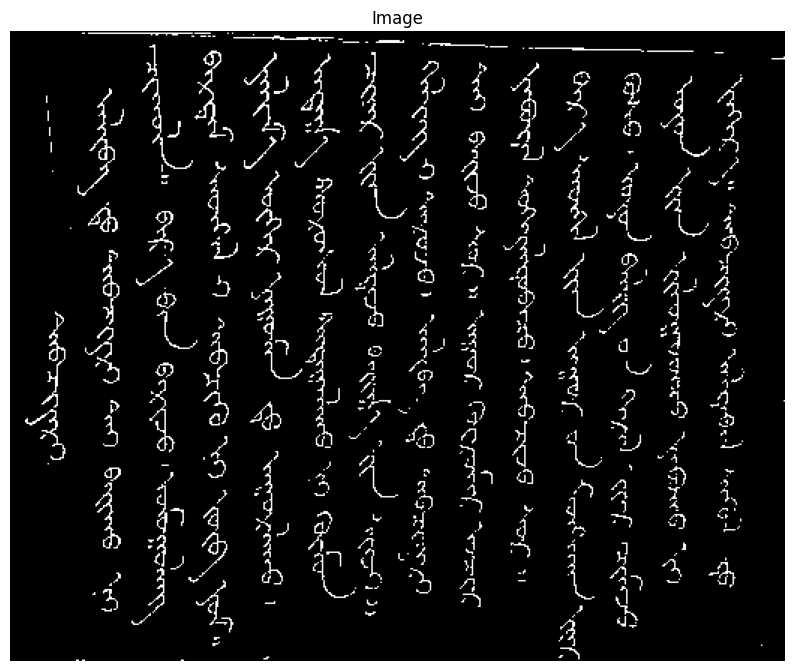

: 

In [ ]:
image_path = "data/mine.png"
output_path = "data/processed_image.png"

image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Kernel 2: Stronger sharpening
kernel_sharpen_2 = np.array([[-1, -1, -1],
                                [-1, 10, -1],
                                [-1, -1, -1]])
kernel_sharpen_3 = np.array([[0, -1, 0],
                                 [-1, 5, -1],
                                 [0, -1, 0]])
sharpened_2 = cv2.filter2D(gray, -1, kernel_sharpen_2)
# ret2, otsu_2 = cv2.threshold(sharpened_2, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
sharpened_3 = cv2.filter2D(sharpened_2, -1, kernel_sharpen_3)

ret3, otsu_3 = cv2.threshold(sharpened_2, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
# ret2, otsu_2 = cv2.threshold(sharpened_2, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
display_image(otsu_3)

In [ ]:
denoised = cv2.fastNlMeansDenoising(sharpened_2, h=30)

# Sharpening kernel
kernel_sharpening = np.array([[-1,-1,-1],
                              [-1, 9,-1],
                              [-1,-1,-1]])
sharpened = cv2.filter2D(denoised, -1, kernel_sharpening)

# Adaptive threshold (good for uneven lighting)
thresh = cv2.adaptiveThreshold(sharpened, 255,
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, 11, 2)

# Save and show result
output_path = "enhanced_output.jpg"
cv2.imwrite(output_path, thresh)
cv2.imshow("Enhanced", thresh)


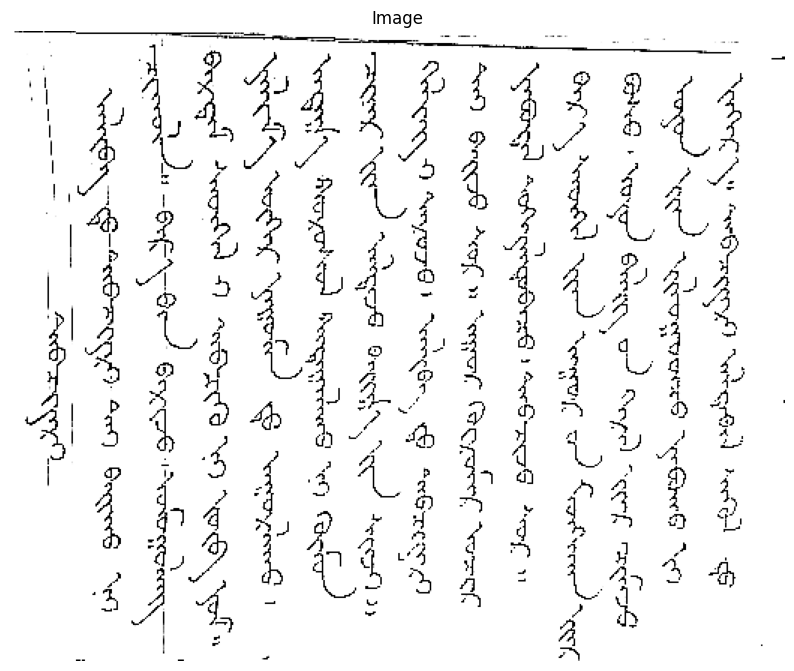

In [25]:
# denoised = cv2.GaussianBlur(sharpened_2, (3, 3), 0)
# denoised = cv2.GaussianBlur(denoised, (3, 3), 0)

# denoised = cv2.medianBlur(sharpened_2, 5)

kernel_sharpening = np.array([[-1,-1,-1],
                              [-1, 9,-1],
                              [-1,-1,-1]])
sharpened = cv2.filter2D(sharpened_2, -1, kernel_sharpening)

# Adaptive threshold (good for uneven lighting)
thresh = cv2.adaptiveThreshold(sharpened, 255,
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, 11, 2)

display_image(sharpened)